In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf
import math
#font CMU Serif
plt.rcParams.update({'font.family': 'cmr10','font.size':'15','axes.formatter.use_mathtext':'True','mathtext.fontset':'cm'})

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>
### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

## <span style="color:purple"> Solution Exercise 07.1</span>

### Problem's Theory:
The NSL_simulator make use of a spherical cut off for potential and pressure. In order to improve the computation of these quantity can be useful compute tails corrections. 
For distances grater than the cut off radius the radial distribution function for two particles $g(r)\approx 1$ because the interaction is assumed to be weak. Tails corrections for a Lennanrd Jones potential can be computed as follow: $$ \left< V_{LJ} \right>{tail} =2\pi\rho N\int{r_c}^\infty dr r^2v(r)g(r)\approx 2\pi\rho\int_{r_c}^\infty dr r^2 4\epsilon\left[\left(\frac{\sigma}{r}\right)^12-\left(\frac{\sigma}{r}\right)^6 \right]=...=\frac{8\pi\rho*}{9r_c^9}-\frac{8\pi\rho*}{3r_c^3}$$
while for the pressure can be shown with similar calculations that: $$ \frac{\left<P*\right>}{3N}=\frac{32\pi\rho*}{9r_c^9}- \frac{32\pi\rho*}{6r_c^3}$$ 


### Problem's approach: 
To insert tail corrections in the NSL_simulator I've modified the intialize properties function. In the part of the code relative to the potential energy I have associated to _vtail the defined above potential value, while in the part of the code relative to the pressure I have associated to  _ptail the defined above pressure value.\
In this way when in measure are calculated potential energy and pressure _vtail and _ptail are respectively added.
### Code:
Code added in intialize properties:
```cpp
  if( property == "POTENTIAL_ENERGY" ){
    _vtail = 8*M_PI*_rho*(1/(9*pow(_r_cut,9))-1/(3*pow(_r_cut,3))); 
```
```cpp
  if( property == "PRESSURE" ){
    _ptail = 32*M_PI*_rho*(1/(9*pow(_r_cut,9))-1/(6*pow(_r_cut,3))); // TO BE FIXED IN EXERCISE 7
```
Code in measure where tails are used to calculate quantities:
```cpp
  if (_measure_penergy){
    penergy_temp = _vtail + 4.0 * penergy_temp / double(_npart);
    _measurement(_index_penergy) = penergy_temp;
  }
```
```cpp
  if(_measure_pressure and _measure_kenergy ){
    _measurement(_index_pressure) = _rho*_measurement(_index_temp) + virial/(3*_volume*double(_npart))+_ptail;
  }
```

### Exercise 07.2
Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along *equilibrated* Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks.
3. Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## <span style="color:purple"> Solution Exercise 07.2</span>

### Problem's approach: 
In this exercise I have perfomed some NVT simulations where is used metropolis algorithm to propose a move every montecarlo time for each particle of the system. As always the acceptance ratio want to be fixed $\approx 50\%$, so a function tha find the best max lenght step has been implemented.\
In this case equilibration is not needed to find the correct temperature becase temperature is fixed, but is usefull to le particle reach the groud state.
### Code:
`find delta` function:
```cpp
void System :: findelta(double acceptance,double precision){
  double fraction=0;
  do{
    _naccepted = 0;
    _nattempts = 0;
    for(int i=0; i < 10; i++){ //loop over blocks
        for(int j=0; j < 100; j++){ //loop over steps in a block
          //cerr << "block: " << i << " iteration: " << j << endl;
          this->step();
          //cerr << "step performed" << endl;
          this->measure();
          //cerr << "measure performed" << endl;
        }
    }
    fraction = double(_naccepted)/double(_nattempts);
    if (fraction > acceptance) {
        _delta *= 1.1; // Increase delta if acceptance rate is too high
    } else {
        _delta *= 0.9; // Decrease delta if acceptance rate is too low
    }
    if(_delta>_side.max()) {_delta = _side.max(); cerr << "delta greater than box size: delta = "<< _delta << " acceptance: "<<fraction<< endl; break;}
  cerr << "delta: " << _delta << " acceptance: " << fraction << endl;
  }while(!(abs(fraction-acceptance)<=precision));
  cerr << "delta found: " << _delta << " acceptance: " << fraction << endl;
}
```
### Results:
- The delta found are correct for the solid and the liquid phase but for the gas phase the function could not find a delta with acceptance ratio lower than $\approx 65\%$. That might be caused by the fact that the particles'interaction is too weak and so Boltzmann distribution tend to accept moves.

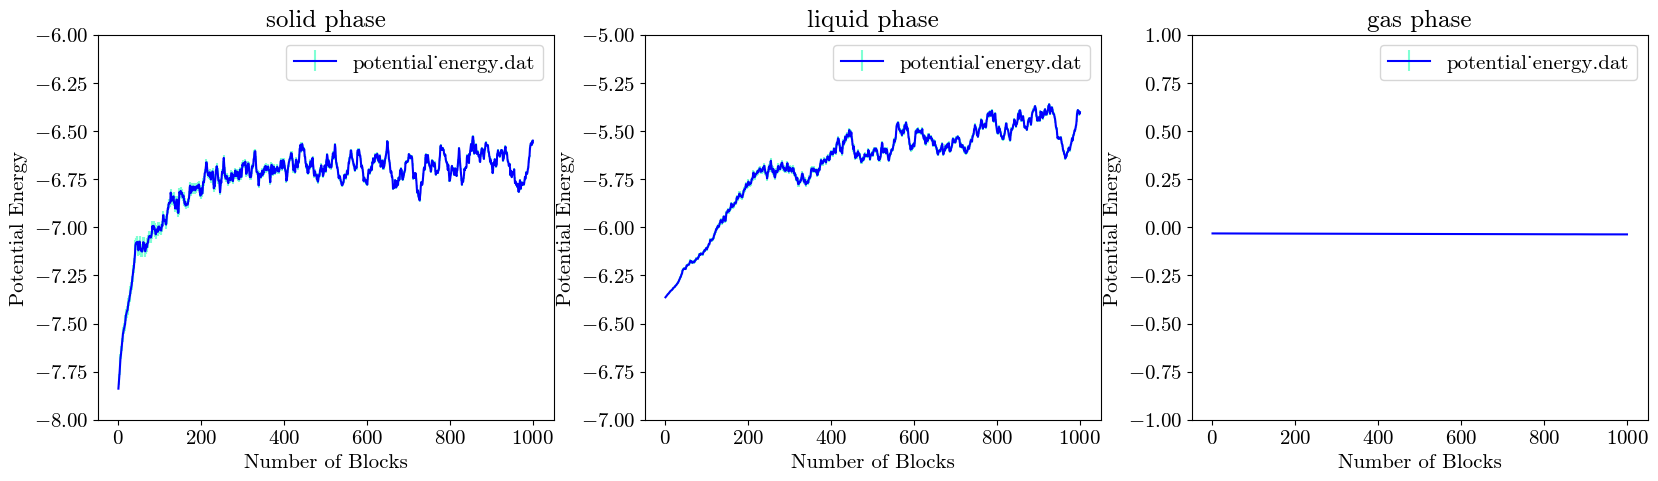

In [3]:
#Equilibration performed:
#Load data from the output file
figure, ax=plt.subplots(1,3,figsize=(20,5))
ylims=[-8,-7,-1]
for phase,i,temp,ylim in zip(['solid','liquid','gas'],[0,1,2],['0.80','1.10','1.20'],ylims):
    for ylabel,energy,colors in zip(['Potential Energy'],['potential_energy.dat'],['blue']):
        file_path='../lecture_4-6-7/Results/output_07.2/equilibration/'+phase+'_phase/temp_'+temp+'/OUTPUT/'+energy
        data=np.loadtxt(file_path,skiprows=1)
        blocks=data[:,0]
        value=data[:,1]
        error=data[:,3]
        ax[i].errorbar(blocks,value,label=energy,yerr=error,color=colors,ecolor='#7fffd4')
        ax[i].legend()
        ax[i].set_xlabel('Number of Blocks')
        ax[i].set_ylabel(ylabel)
        ax[i].set_ylim(ylim,ylim+2)
        ax[i].set_title(phase+' phase')


Plots above shows equilibration of the three phases. As we can see the liquid one is the slower one while the gas is the faster.

In [4]:
# Load data from the output.txt file
file_path_solid = '../lecture_4-6-7/Results/output_07.2/simulation_equilibrated/solid/OUTPUT/potential_energy.dat'
file_path_liquid = '../lecture_4-6-7/Results/output_07.2/simulation_equilibrated/liquid/OUTPUT/potential_energy.dat'
file_path_gas = '../lecture_4-6-7/Results/output_07.2/simulation_equilibrated/gas/OUTPUT/potential_energy.dat'
solid_data = np.loadtxt(file_path_solid, skiprows=1)  # Skip the first row (header)
liquid_data = np.loadtxt(file_path_liquid, skiprows=1)  # Skip the first row (header)
gas_data = np.loadtxt(file_path_gas, skiprows=1)  # Skip the first row (header)
# Extract columns 
t = solid_data[:, 0]
N=108 #number of particles
solid_actual_pe = solid_data[:, 1]
liquid_actual_pe = liquid_data[:, 1]
gas_actual_pe = gas_data[:, 1]


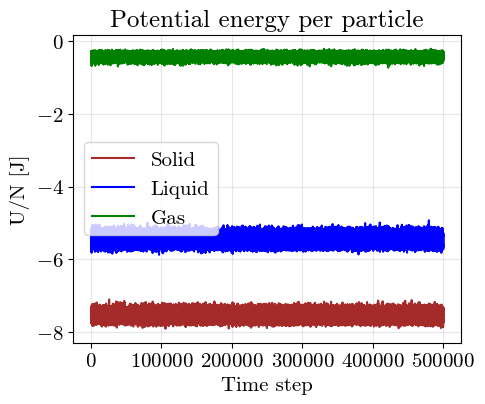

In [6]:
#plot the potential energy for the three phases
figura, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t, solid_actual_pe, label='Solid', color='brown')
ax.plot(t, liquid_actual_pe, label='Liquid', color='blue')
ax.plot(t, gas_actual_pe, label='Gas', color='green')
ax.legend()
ax.set_xlabel('Time step')
ax.set_ylabel('U/N [J]')
ax.grid(True,alpha=0.3)
ax.set_title('Potential energy per particle')
plt.show()

The plot above shows the instantaneous values of the potential energi per particle for the solid, liquid and gas phase. As expected the sistems are at the equilibrium, in fact $U$ fluctuates but doesn't change in time.\
As exepcted the potential energy decrease progressively as the interactions between particles becomes stronger.

## `acf` Function in `statsmodels`

The `acf` function from the `statsmodels.tsa.stattools` module calculates the autocorrelation function (ACF) of a time series. The ACF measures the correlation between the time series values and their lagged values over different lags. This function is crucial for identifying patterns, trends, and the nature of the time series data.

### Autocorrelation Function (ACF)

The autocorrelation function at lag $k$ is given by:

$ \rho_k = \frac{\gamma_k}{\gamma_0} $

where:
- $\rho_k$ is the autocorrelation at lag $k$.
- $\gamma_k$ is the autocovariance at lag $k$.
- $\gamma_0$ is the variance of the time series (i.e., the autocovariance at lag 0).

### Autocovariance

The autocovariance at lag $k$ is calculated as:

$ \gamma_k = \frac{1}{n} \sum_{t=k+1}^{n} (x_t - \bar{x})(x_{t-k} - \bar{x}) $

where:
- $x_t$ is the value of the time series at time $t$.
- $\bar{x}$ is the mean of the time series.
- $n$ is the length of the time series.

### Steps to Compute the ACF

1. **Calculate the Mean**: Compute the mean ($\bar{x}$) of the time series.
2. **Compute the Autocovariance**: Calculate the autocovariance ($\gamma_k$) for each lag $k$ up to the specified number of lags.
3. **Normalize**: Normalize each autocovariance by the variance ($\gamma_0$) to get the autocorrelation ($\rho_k$).

### Python Implementation

Here’s a manual implementation of the ACF calculation:

```python
import numpy as np

def acf_manual(time_series, max_lag):
    """
    Calculate the autocorrelation function for a time series manually.
    
    Parameters:
    time_series (array-like): The time series data.
    max_lag (int): The maximum lag for which to calculate the ACF.
    
    Returns:
    array: ACF values for lags from 0 to max_lag.
    """
    n = len(time_series)
    mean = np.mean(time_series)
    var = np.var(time_series)
    acf = []

    for lag in range(max_lag + 1):
        if lag == 0:
            acf.append(1)  # ACF at lag 0 is always 1
        else:
            cov = np.sum((time_series[:n-lag] - mean) * (time_series[lag:] - mean)) / n
            acf.append(cov / var)

    return np.array(acf)


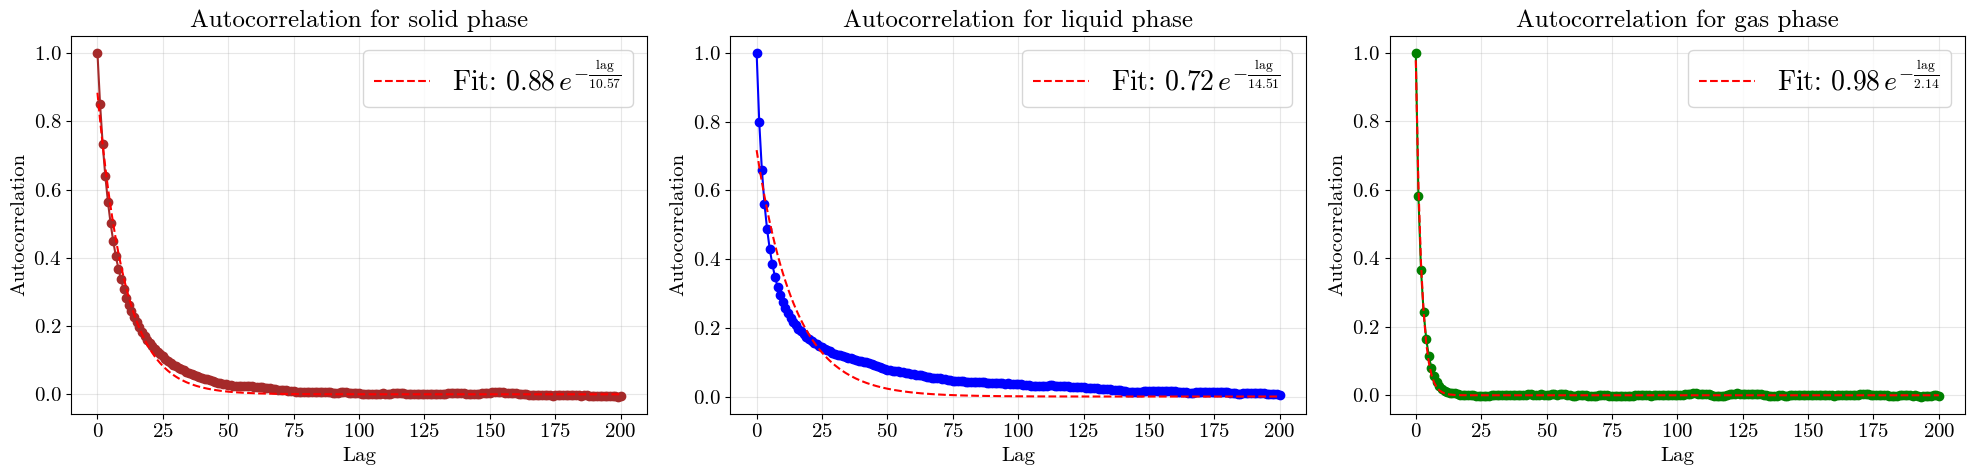

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

def exponential_fit(x, a, b):
    return a * np.exp(-x/b)
#defining variables
time_series = [solid_actual_pe,liquid_actual_pe,gas_actual_pe]
fig, axs = plt.subplots(1,3,figsize=(20,5))
# Calculate ACF using statsmodels
max_lag = 200  # Adjust this value based on how many lags you want to plot
lags = np.arange(max_lag + 1)
idxs=[0,1,2]
colors=['brown','blue','green']
phases=['solid','liquid','gas']
for time_serie,idx,color,phase in zip(time_series,idxs,colors,phases):
    acf_values = acf(time_serie, nlags=max_lag)
    # Plot the ACF against lag
    axs[idx].plot(lags, acf_values, marker='o', linestyle='-',color=color)
    axs[idx].set_xlabel('Lag')
    axs[idx].set_ylabel('Autocorrelation')
    axs[idx].set_title('Autocorrelation for '+phase+' phase')
    axs[idx].grid(True,alpha=0.3)
    # Perform an exponential fit
    popt, pcov = curve_fit(exponential_fit, lags, acf_values)
    fit_a, fit_b = popt
    # Plot the exponential fit
    fit_values = exponential_fit(lags, *popt)
    axs[idx].plot(lags, fit_values, linestyle='--', color='red', label=f'Fit: ${fit_a:.2f} \\, e^{{-\\frac{{\\text{{lag}}}}{{{fit_b:.2f}}}}}$')
    axs[idx].legend(fontsize='20')
plt.tight_layout()

The plots show the autocorrelation in function of the lag. As we can see the gas lag is the smaller while the liquid lag is the biggest. This is due to two facts:
- The gas $\tau$ is really small because the particle interaction is realli weak so there is an high degree of disorder in the system.
- In the liquid state there is mobility between particles and the energy interaction is quite strong so there is an higher correlation than in a solid where the particles oscillate around an equilibrium point and so there's no significant movement.

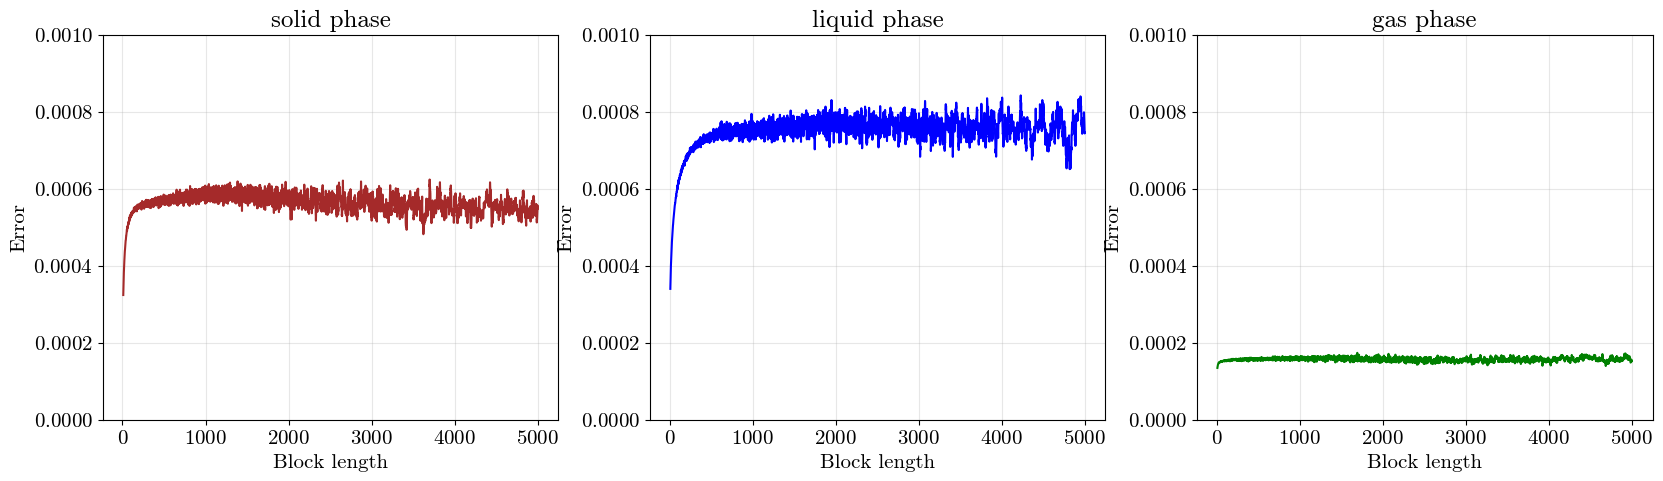

In [9]:
def error(AV, AV2, n):  # Function for statistical uncertainty estimation
    if n == 0:
        return 0
    else:
        return np.sqrt((AV2 - AV**2) / n)

figure,ax=plt.subplots(1,3,figsize=(20,5))
M = 500000
Lin = 10
Lfin = 5000
vec_L = np.arange(Lin, Lfin)  # Total number of throws
x = np.zeros(Lfin - Lin)
for phase,i,colors,r in zip(['solid','liquid','gas'],[0,1,2],['brown','blue','green'],[solid_actual_pe,liquid_actual_pe,gas_actual_pe]):
    for idx, L in enumerate(vec_L):
        N = M // L  # Number of blocks
        reshaped_r = r[:L * N].reshape(N, L)
        
        ave = np.mean(reshaped_r, axis=1)  # Mean of each block
        av2 = ave**2
        
        sum_prog = np.mean(ave)
        su2_prog = np.mean(av2)
        
        err_prog = error(sum_prog, su2_prog, N)
        x[idx] = err_prog
    
    ax[i].plot(vec_L, x,color=colors)
    ax[i].set_title(phase+' phase')
    ax[i].set_xlabel('Block length')
    ax[i].set_ylabel('Error')
    ax[i].set_ylim(0,0.001)
    ax[i].grid(True,alpha=0.3)

This plots show how the statistical error changes while the Lenght of the block becomes grater. We see that after that $L_{block}\gt 1000$ the error reaches a plateau, while before is underestimate due to correlations. So a good measure for $L_block$ is $1000$.
### Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

## <span style="color:purple"> Solution Exercise 07.3</span>

### Problem's Theory: 
To describe the structures of materials are used distribution functions for the atomic positions, the simplest of this is the radial distribution function $g(r_i,r_j)$ that describes the probability of finding two atoms at a certain distance, relative to the probability expecte for a random distribution.\
The definition of $g(r)$ begins from the **n-particle desities** $$ \rho_N(\vec{r}_1,..,\vec{r}_n)=\frac{N!}{(N-n)!}\int dr_{n+1}...dr_N \frac{e^{-\beta V(\vec{r}_1,...,\vec{r}_N)}}{Z}$$. The n-particles distribution function is defined as: $$ g_N^{(n)}(\vec{r}_1,...,\vec{r}_N)=\frac{\rho_N^{(n)}(\vec{r}_1,...,\vec{r}_N)}{\prod_{i=1}^N\rho_N^{(1)}(\vec{r}_i)}$$ where $\rho_N^{(1)}(\vec{r}_i)=\frac{N}{V}$ for an homogeneous system.\
The pair distribution is imprtant not only because it gives structure information, but because any pair function can be computed disrectly knowing it.\
To buil up an algorithim for the computation of the two particles density can be noted that: $$ \left<\delta(\vec{r}-\vec{r}_1)\right>\left<\delta(\vec{r}'-\vec{r}_2)\right>=\int d\vec{r}_3...d\vec{r}_N\frac{e^{-\beta V(\vec{r},\vec{r}',...,\vec{r}_N)}}{Z}$$ so it follows that: $$ \rho_N^{(2)}(\vec{r},\vec{r}')=\left<\sum\sum_{i\neq j=i}^{N}\delta(\vec{r}-\vec{r}_1)\delta(\vec{r}'-\vec{r}_2)\right>$$
In an homogeneus liquid where $g^2(\vec{r}_1,\vec{r}_2)=g^2(|\vec{r}_1-\vec{r}_2|)=g(r)$ can be shown that: 
$$ g(\vec{r})=\frac{1}{\rho N}=\left<\sum\sum_{i\neq j=i}^{N}\delta\left[\vec{r}-\left(\vec{r}_i-\vec{r}_j\right)\right]\right>$$ 
so 
$$ g(r)=\left<g(\vec{r})\right>_{r,\theta,\phi}=\frac{1}{\rho N \Delta V(r)}\left<\sum\sum_{i\neq j=i}^{N}\delta\left[|\vec{r}|-|\vec{r}_i-\vec{r}_j|\right]\right>$$ 
where $\Delta V(r):=\frac{4\pi}{3}\left[\left(r+dr\right)^3-r^3\right]$

### Problem's approach:
During the simulation when $g(r)$ is computed i have created an histrogram whose bins are increased by $2$ when two particles at a certain distance $d\in[r,r+dr]$ are found. To do so:
- In the `initialize properties` method, when the $g(r)$ part of the code is reached, I've incremented  the number and indexes of properties measured by the number of bins. In addition is defined the bins' size and two files for the writing of the bins values during measures and at the end of the simulation named respectively: `gofr.dat` and `gofr_final.dat`.\
- In the `measure` method I've implemented a double for cycle that increase every bin of two when two particle are found at a certain distance.
- In the `averages` method i've added the classic part of the code to calculate the block average of a certain quantity, but, in addition, i've added a part that write on `gofr_final.dat` only the histogram of the last block.

### Code:
In `initialize properties` the code is:
```cpp
 if( property == "GOFR" ){
    ofstream coutgr("../OUTPUT/gofr.dat");
    coutgr << "# DISTANCE:     AVE_GOFR:        ERROR:" << endl;
    coutgr.close();
    ofstream coutgrf("../OUTPUT/gofr_final.dat");
    coutgrf << "# DISTANCE:     AVE_GOFR:        ERROR:" << endl;
    coutgrf.close();
    input>>_n_bins;
    _nprop+=_n_bins;
    _bin_size = (_halfside.min() )/(double)_n_bins;
    _measure_gofr = true;
    _index_gofr = index_property;
    index_property+= _n_bins;
      }
```
In `measure` the code is:
```cpp
  if (_measure_penergy or _measure_pressure or _measure_gofr) {
    for (int i=0; i<_npart-1; i++){
      for (int j=i+1; j<_npart; j++){
      ... other parts of code ...
        if(_measure_gofr){
          bin = int(dr/_bin_size);
          if(bin < _n_bins) _measurement(_index_gofr+bin) += (2.0/(DeltaV*_rho));
        }
      }
    }
  }
```
In `averages` the code is:
```cpp
  if(_measure_gofr){
    coutf.open("../OUTPUT/gofr.dat",ios::app);
    for(int i=0; i<_n_bins; i++){
      average  = _average(_index_gofr+i);
      sum_average = _global_av(_index_gofr+i);
      sum_ave2 = _global_av2(_index_gofr+i);
      coutf << setw(12) << i+_block_counter
            << setw(12) << average/double(_npart)
            << setw(12) << this->error(sum_average, sum_ave2, blk) << endl;
    }
    coutf.close();
    _block_counter++;
    if(_block_counter==_nblocks){
      coutf.open("../OUTPUT/gofr_final.dat",ios::app);
      for(int i=0; i<_n_bins; i++){
        average  = _average(_index_gofr+i);
        sum_average = _global_av(_index_gofr+i);
        sum_ave2 = _global_av2(_index_gofr+i);
        coutf << setw(12) << i
              << setw(12) << average/double(_npart)
              << setw(12) << this->error(sum_average, sum_ave2, blk) << endl;
      }
      coutf.close();
    }
  }
```
### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

## <span style="color:purple"> Solution Exercise 07.4</span>
### Results:
In the following plots I have computed the NVT and NVE simulations for solid, liquid and gas phase. In particular i have computed, after equilibration for NVE and NVT systems, three properties of the system: potential energy, pressure and $g(r)$.
### Plot parameters:
- $N_{blocks}=500$
- $L_{block}=1000$


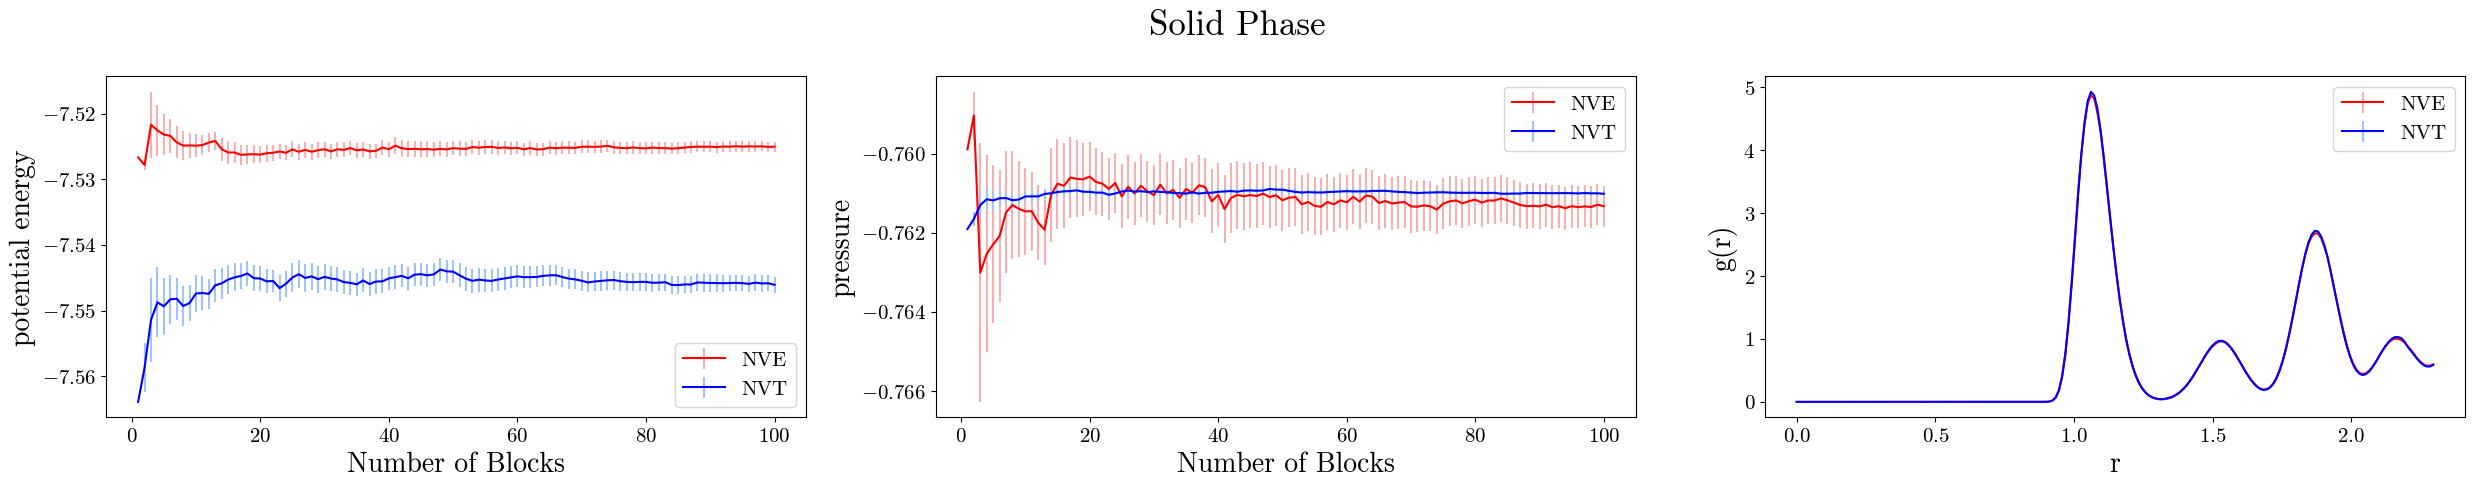

In [12]:
#--------------------------------------------------------------------------------#
# Potential Energy Pressure and Radial distribution of Argon. NVT NVE comparison #
#--------------------------------------------------------------------------------#


# SOLID PHASE #
fig, axs = plt.subplots(1,3,figsize=(25,5))
fig.suptitle('Solid Phase',fontsize=25)
phase='solid'
idxs=[0,1,2]
indexes=[0,1,2]
cols=[4,4,3]
sim_types=['../lecture_4-6-7/Results/output_07.4/NVE/','../lecture_4-6-7/Results/output_07.4/NVT/']
types=['NVE','NVT']
for sim_type,type,idx,typecolor,ecolor in zip(sim_types,types,idxs,['red','blue'],['#F6B2B2','#A0C2FE']):
    for file,idx2,ylab in zip(['potential_energy.dat','pressure.dat','gofr_final.dat'],idxs,['potential energy','pressure','g(r)']):
        data=np.loadtxt(sim_type+phase+'/OUTPUT/'+file)
        if(file!='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,2],color=typecolor,yerr=data[:,3],ecolor=ecolor,label=type)
            axs[idx2].set_xlabel('Number of Blocks',fontsize=20)
            axs[idx2].set_ylabel(ylab,fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
        if(file=='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,1],color=typecolor,yerr=data[:,2],ecolor=ecolor,label= type)
            axs[idx2].set_xlabel('r',fontsize=20)
            axs[idx2].set_ylabel('g(r)',fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
plt.tight_layout()            

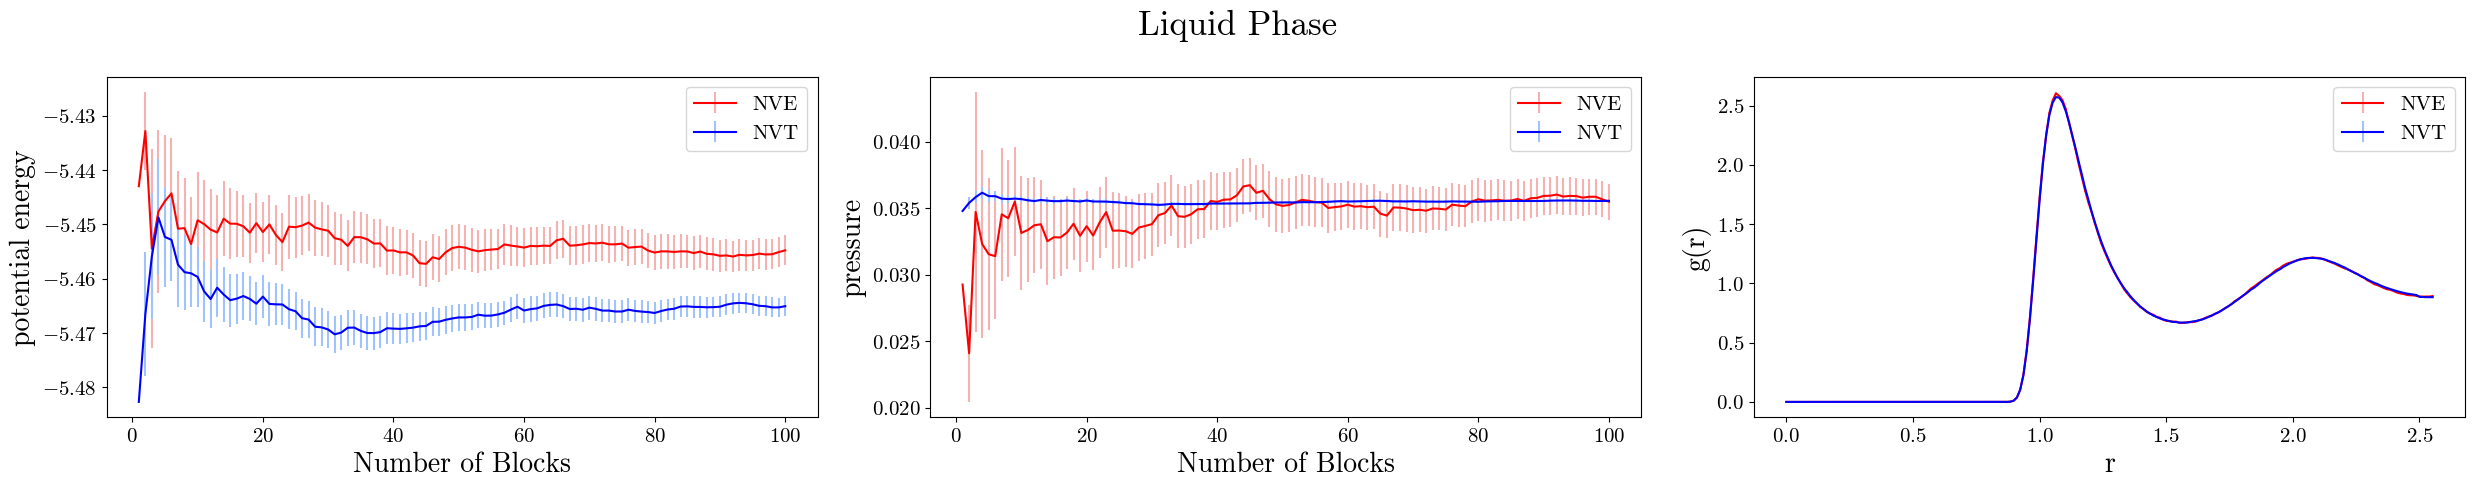

In [13]:
# LIQUID PHASE #
fig, axs = plt.subplots(1,3,figsize=(25,5))
fig.suptitle('Liquid Phase',fontsize=25)
phase='liquid'
idxs=[0,1,2]
indexes=[0,1,2]
cols=[4,4,3]
sim_types=['../lecture_4-6-7/Results/output_07.4/NVE/','../lecture_4-6-7/Results/output_07.4/NVT/']
types=['NVE','NVT']
for sim_type,type,idx,typecolor,ecolor in zip(sim_types,types,idxs,['red','blue'],['#F6B2B2','#A0C2FE']):
    for file,idx2,ylab in zip(['potential_energy.dat','pressure.dat','gofr_final.dat'],idxs,['potential energy','pressure','g(r)']):
        data=np.loadtxt(sim_type+phase+'/OUTPUT/'+file)
        if(file!='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,2],color=typecolor,yerr=data[:,3],ecolor=ecolor,label=type)
            axs[idx2].set_xlabel('Number of Blocks',fontsize=20)
            axs[idx2].set_ylabel(ylab,fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
        if(file=='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,1],color=typecolor,yerr=data[:,2],ecolor=ecolor,label= type)
            axs[idx2].set_xlabel('r',fontsize=20)
            axs[idx2].set_ylabel('g(r)',fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
plt.tight_layout()

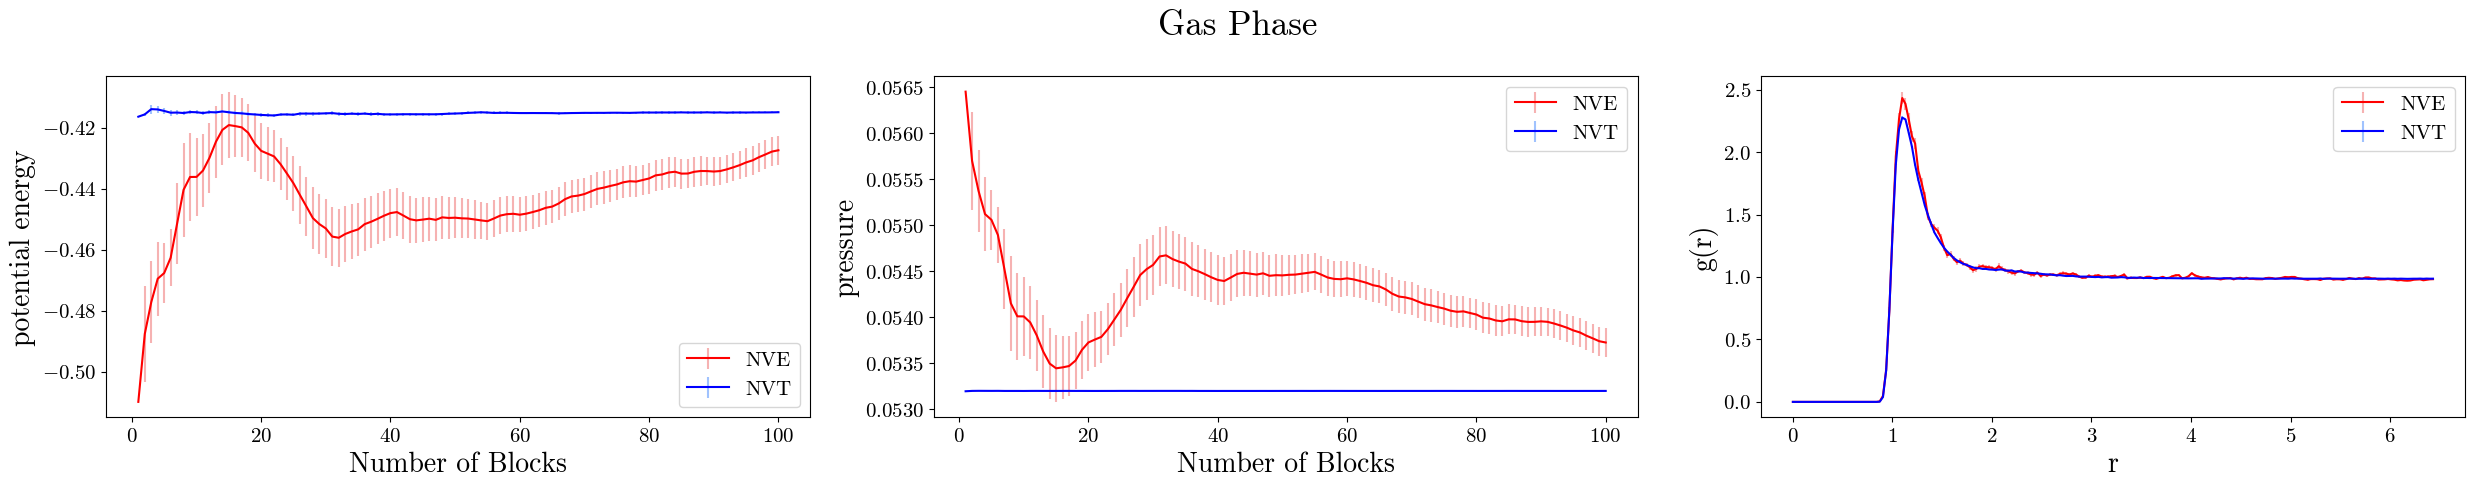

In [14]:
# GAS PHASE #
fig, axs = plt.subplots(1,3,figsize=(25,5))
fig.suptitle('Gas Phase',fontsize=25)
phase='gas'
idxs=[0,1,2]
indexes=[0,1,2]
cols=[4,4,3]
sim_types=['../lecture_4-6-7/Results/output_07.4/NVE/','../lecture_4-6-7/Results/output_07.4/NVT/']
types=['NVE','NVT']
for sim_type,type,idx,typecolor,ecolor in zip(sim_types,types,idxs,['red','blue'],['#F6B2B2','#A0C2FE']):
    for file,idx2,ylab in zip(['potential_energy.dat','pressure.dat','gofr_final.dat'],idxs,['potential energy','pressure','g(r)']):
        data=np.loadtxt(sim_type+phase+'/OUTPUT/'+file)
        if(file!='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,2],color=typecolor,yerr=data[:,3],ecolor=ecolor,label=type)
            axs[idx2].set_xlabel('Number of Blocks',fontsize=20)
            axs[idx2].set_ylabel(ylab,fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
        if(file=='gofr_final.dat'): 
            axs[idx2].errorbar(data[:,0],data[:,1],color=typecolor,yerr=data[:,2],ecolor=ecolor,label= type)
            axs[idx2].set_xlabel('r',fontsize=20)
            axs[idx2].set_ylabel('g(r)',fontsize=20)
            #axs[idx2].set_title(phase+' phase: '+ylab)
            axs[idx2].legend()
plt.tight_layout()

As we can see, all three different $g(r)$ values initially start at zero due to the high repulsion of the L-J potential. After this phase, there is a steep rise with a peak for all three phases, representing the most probable distance between particles. The solid $g(r)$ shows several pronounced peaks, the liquid $g(r)$ displays fewer and less pronounced peaks, while the gas $g(r)$ shows no additional peaks.

The reason for this is that particles are freer to move in the gas phase, resulting in no fixed distances, whereas in the solid phase, the atoms are fixed. As expected for all the three plots the $g(r)\approx 1$ because the interaction decrease and the particle distribution is random.